### Date: 10th March 2023
### Joseph Antony

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import qgrid
from tqdm.auto import tqdm
import re

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
def show_tbl(df):
    return qgrid.show_grid(df, show_toolbar=True)

In [3]:
#Imputed AQ
df1 = pd.read_csv("datasets/AirQuality_Imputed_PowiatLvl.csv", parse_dates=['DATE'])

#Imputed Weather
df2 = pd.read_csv("datasets/Weather_Imputed_PowiatLvl.csv", parse_dates=['DATE']).\
        drop(['QQ', 'PP', 'SS'], axis=1)

#Powiat Proximity
df3 = pd.read_excel("datasets/powiat_proximity.xlsx")

In [4]:
#Number of unique powiats in AQ
len(df1['powiat_voivod'].unique())

198

In [5]:
#Number of unique powiats in weather
len(df2['powiat_voivod'].unique())

86

In [6]:
#136 unique powiats in AQ not present in weather
len(
    np.setdiff1d(
        df1['powiat_voivod'].unique(),
        df2['powiat_voivod'].unique()
    )
)

AQ_unique_powiats = np.setdiff1d(df1['powiat_voivod'].unique(), df2['powiat_voivod'].unique())

In [7]:
#24 unique powiats in weather not present in AQ
len(
    np.setdiff1d(
        df2['powiat_voivod'].unique(),
        df1['powiat_voivod'].unique()
    )
)

24

In [8]:
#Joining datasets using left join (AQ <- weather) to check for nulls
df1.merge(
    df2.drop(['LAT', 'LON'], axis=1), 
    how='left', 
    on=['powiat_voivod', 'DATE']
).isnull().sum()/len(df1)*100

powiat_voivod              0.000000
DATE                       0.000000
LAT                        0.000000
LON                        0.000000
NO2_24H_AVG_POLLUTION     98.484848
O3_24H_AVG_POLLUTION      48.989899
PM10_24H_AVG_POLLUTION     9.090909
PM25_24H_AVG_POLLUTION    65.656566
CC                        76.262626
FG                        71.212121
HU                        73.737374
RR                        71.717172
SD                        72.222222
TG                        72.222222
dtype: float64

In [9]:
#Taking unique AQ powiats
AQ = df1[['powiat_voivod']].drop_duplicates()

#Taking unique weather powiats
weather = df2[['powiat_voivod']].drop_duplicates()

In [10]:
#Merging AQ and weather powiats.
merged_powiats = pd.concat([AQ, weather]).drop_duplicates().\
                     sort_values(by="powiat_voivod", ignore_index=True)

In [11]:
#transforming powist-proximity columns to lower string format.
all_powiats_voivodship = [col.lower() for col in df3.columns]
df3.columns = all_powiats_voivodship

In [12]:
#All merged powiats are present in powist-proximity dataset
len(np.setdiff1d(merged_powiats['powiat_voivod'].unique(), all_powiats_voivodship))

0

In [13]:
#Extracting voivodship from the powiat_voivod column
merged_powiats['voivodship'] = merged_powiats['powiat_voivod'].str.split(", ").str[1]

In [14]:
#Function to extract nearest powiat and its distance
def regex_extract(col, df3, ix):
    
    string = df3[col][ix].rsplit(",", 1)[0]
    dist = df3[col][ix].rsplit(",", 1)[1]
    
    return re.search("'(.+)'", string).group(1), round(float(re.search("(\d+\.\d+)", dist).group(1)), 6)

In [15]:
#Will create cols for the 12 most nearest cols for a powiat and its corresponsing distance
LIMIT = 12

for i in range(0, LIMIT):
    merged_powiats[f"near_{i+1}_pw"], merged_powiats[f"near_{i+1}_dist"]= \
    zip(*merged_powiats['powiat_voivod'].apply(lambda x: regex_extract(col=x, df3=df3, ix=i)))
    
print(f'Max Distance from a powiat: {merged_powiats[f"near_{LIMIT}_dist"].max()}')

Max Distance from a powiat: 114.437385


In [16]:
merged_powiats.head(3)

,powiat_voivod,voivodship,near_1_pw,near_1_dist,near_2_pw,near_2_dist,near_3_pw,near_3_dist,near_4_pw,near_4_dist,...,near_8_pw,near_8_dist,near_9_pw,near_9_dist,near_10_pw,near_10_dist,near_11_pw,near_11_dist,near_12_pw,near_12_dist
0,"powiat aleksandrowski, kujawsko-pomorskie",kujawsko-pomorskie,"powiat włocławski, kujawsko-pomorskie",22.403258,"powiat radziejowski, kujawsko-pomorskie",25.114076,"powiat Toruń, kujawsko-pomorskie",25.941470,"powiat Włocławek, kujawsko-pomorskie",26.666417,...,"powiat golubsko-dobrzyński, kujawsko-pomorskie",39.347636,"powiat mogileński, kujawsko-pomorskie",47.907526,"powiat rypiński, kujawsko-pomorskie",53.602727,"powiat wąbrzeski, kujawsko-pomorskie",55.168741,"powiat chełmiński, kujawsko-pomorskie",57.760728
1,"powiat augustowski, podlaskie",podlaskie,"powiat sejneński, podlaskie",32.932461,"powiat Suwałki, podlaskie",33.825429,"powiat suwalski, podlaskie",42.881834,"powiat sokólski, podlaskie",44.408508,...,"powiat olecki, warmińsko-mazurskie",52.663503,"powiat gołdapski, warmińsko-mazurskie",72.452479,"powiat Białystok, podlaskie",75.898751,"powiat białostocki, podlaskie",79.822553,"powiat piski, warmińsko-mazurskie",85.054714
2,"powiat bełchatowski, łódzkie",łódzkie,"powiat łaski, łódzkie",23.378260,"powiat pajęczański, łódzkie",27.488455,"powiat Piotrków Trybunalski, łódzkie",32.380940,"powiat piotrkowski, łódzkie",33.582917,...,"powiat łódzki wschodni, łódzkie",45.445601,"powiat wieluński, łódzkie",45.651965,"powiat Łódź, łódzkie",47.975160,"powiat sieradzki, łódzkie",51.345898,"powiat kłobucki, śląskie",54.309572


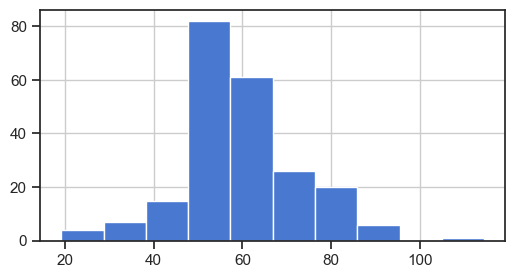

In [17]:
#Histogram of the 12th most nearest to a powiat
merged_powiats[f'near_{LIMIT}_dist'].hist(figsize=(6, 3));

In [18]:
weather_cols = ['CC', 'FG', 'HU', 'RR', 'SD', 'TG']

In [19]:
#Creating a weather dataframw that contains all powiats in df2 (original imputed weather data) and
#those 136 powiats in AQ that are not in df2.

weather_impute=\
pd.concat([
    df2.loc[:, : "TG"],
    df1.loc[df1['powiat_voivod'].isin(AQ_unique_powiats), ['powiat_voivod', 'DATE']]
],ignore_index=True)

In [20]:
#Total 222 powiats
len(weather_impute['powiat_voivod'].unique())

222

In [21]:
#Extracting voivodship
weather_impute['voivodship'] = weather_impute['powiat_voivod'].str.split(", ").str[1]

In [22]:
#Creating a dictionary that consists of powiats and their corresponding null weather variables

#First grouping by and getting a list of powiats and their corresponding null status(True or False) for 
#each weather
null_dict = \
weather_impute.groupby("powiat_voivod")[weather_cols].apply(lambda x: x.isnull().all()).to_dict()

# Filtering only those powiats with True status for nulls
for col in null_dict:
    null_dict[col] = {k : v for k, v in null_dict[col].items() if v==True}

In [23]:
#Null proportion status of weather data
weather_impute.isnull().sum()/len(weather_impute)*100

powiat_voivod     0.000000
DATE              0.000000
CC               70.270270
FG               64.864865
HU               68.018018
RR               63.963964
SD               65.765766
TG               64.414414
voivodship        0.000000
dtype: float64

In [24]:
%%time

#First iterating over weather
#The iterating over those powiats that has null values for that particular weather

for weather in tqdm(weather_cols):
    
    print()
    print(f"Imputing {weather}")
    
    for k in tqdm(null_dict[weather].keys()):
        
        #Using a while loop to go thorugh each nth nearest station starting from 1.
        #For eg, if Powiat A has no data for weather 'CC'. I look for the corresponding nearest 1st powiat, 
        #and check whether the nearest 1st powiat has data for 'CC'.
        #If yes, then I will impute the null values of Powiat A with nearest 1st powiat data.
        #If no, then I move to nearest 2nd powiat, and so on.
        #The counter keeps a count of the loop
        
        #If the counter is equal to the LIMIT (12), that means we have looked through the last nearest
        #powiat, and still there is no weather data. In this case, we just move on to the next powiat.
        
        #Those that reaches the LIMIT will be taken care of in the next section.
        
        cntr=1
        while cntr<=LIMIT:

            near_pw = merged_powiats.query(f"powiat_voivod=='{k}'")[f'near_{cntr}_pw'].values[0]

            if weather_impute.loc[weather_impute['powiat_voivod'].eq(near_pw), weather].isnull().all():
                
                if cntr==LIMIT:
                    print(f"No {weather} data for: {k}")
                       
                cntr += 1
                
            else:
                #Imputing
                weather_impute.loc[weather_impute['powiat_voivod'].eq(k), weather] = \
                weather_impute.loc[weather_impute['powiat_voivod'].eq(near_pw), weather].values
                
                #Noting the distance between the nth nearest powiat and the powiat being imputed
                weather_impute.loc[weather_impute['powiat_voivod'].eq(k), 'nearest_powiat_dist'] = \
                merged_powiats.query(f"powiat_voivod=='{k}'")[f'near_{cntr}_dist'].values[0]
                
                #Also indicating those powiats and its mode of imputing.
                weather_impute.loc[weather_impute['powiat_voivod'].eq(k), 'impute_type'] = \
                f"Nearest {cntr} Powiat"
                
                break        

  0%|          | 0/6 [00:00<?, ?it/s]


Imputing CC


  0%|          | 0/156 [00:00<?, ?it/s]

No CC data for: powiat bolesławiecki, dolnośląskie
No CC data for: powiat brodnicki, kujawsko-pomorskie
No CC data for: powiat brzeziński, łódzkie
No CC data for: powiat gliwice, śląskie
No CC data for: powiat gliwicki, śląskie
No CC data for: powiat gryfiński, zachodniopomorskie
No CC data for: powiat głogowski, dolnośląskie
No CC data for: powiat krośnieński, lubuskie
No CC data for: powiat milicki, dolnośląskie
No CC data for: powiat myśliborski, zachodniopomorskie
No CC data for: powiat nowosolski, lubuskie
No CC data for: powiat polkowicki, dolnośląskie

Imputing FG


  0%|          | 0/144 [00:00<?, ?it/s]

No FG data for: powiat aleksandrowski, kujawsko-pomorskie
No FG data for: powiat bolesławiecki, dolnośląskie
No FG data for: powiat brodnicki, kujawsko-pomorskie
No FG data for: powiat brzeziński, łódzkie
No FG data for: powiat bydgoszcz, kujawsko-pomorskie
No FG data for: powiat chełmiński, kujawsko-pomorskie
No FG data for: powiat cieszyński, śląskie
No FG data for: powiat gliwice, śląskie
No FG data for: powiat gliwicki, śląskie
No FG data for: powiat gnieźnieński, wielkopolskie
No FG data for: powiat grudziądz, kujawsko-pomorskie
No FG data for: powiat głogowski, dolnośląskie
No FG data for: powiat inowrocławski, kujawsko-pomorskie
No FG data for: powiat milicki, dolnośląskie
No FG data for: powiat mogileński, kujawsko-pomorskie
No FG data for: powiat nowosolski, lubuskie
No FG data for: powiat polkowicki, dolnośląskie
No FG data for: powiat toruński, kujawsko-pomorskie
No FG data for: powiat wysokomazowiecki, podlaskie

Imputing HU


  0%|          | 0/151 [00:00<?, ?it/s]

No HU data for: powiat aleksandrowski, kujawsko-pomorskie
No HU data for: powiat bolesławiecki, dolnośląskie
No HU data for: powiat brodnicki, kujawsko-pomorskie
No HU data for: powiat brzeziński, łódzkie
No HU data for: powiat bydgoszcz, kujawsko-pomorskie
No HU data for: powiat chełmiński, kujawsko-pomorskie
No HU data for: powiat cieszyński, śląskie
No HU data for: powiat gliwice, śląskie
No HU data for: powiat gliwicki, śląskie
No HU data for: powiat gnieźnieński, wielkopolskie
No HU data for: powiat grudziądz, kujawsko-pomorskie
No HU data for: powiat głogowski, dolnośląskie
No HU data for: powiat inowrocławski, kujawsko-pomorskie
No HU data for: powiat milicki, dolnośląskie
No HU data for: powiat mogileński, kujawsko-pomorskie
No HU data for: powiat nowosolski, lubuskie
No HU data for: powiat polkowicki, dolnośląskie
No HU data for: powiat toruński, kujawsko-pomorskie
No HU data for: powiat wysokomazowiecki, podlaskie

Imputing RR


  0%|          | 0/142 [00:00<?, ?it/s]

No RR data for: powiat bolesławiecki, dolnośląskie
No RR data for: powiat brodnicki, kujawsko-pomorskie
No RR data for: powiat gliwice, śląskie
No RR data for: powiat gliwicki, śląskie
No RR data for: powiat głogowski, dolnośląskie
No RR data for: powiat kalisz, wielkopolskie
No RR data for: powiat milicki, dolnośląskie
No RR data for: powiat nowosolski, lubuskie
No RR data for: powiat polkowicki, dolnośląskie

Imputing SD


  0%|          | 0/146 [00:00<?, ?it/s]

No SD data for: powiat bolesławiecki, dolnośląskie
No SD data for: powiat brodnicki, kujawsko-pomorskie
No SD data for: powiat gliwice, śląskie
No SD data for: powiat gliwicki, śląskie
No SD data for: powiat głogowski, dolnośląskie
No SD data for: powiat milicki, dolnośląskie
No SD data for: powiat nowosolski, lubuskie
No SD data for: powiat polkowicki, dolnośląskie

Imputing TG


  0%|          | 0/143 [00:00<?, ?it/s]

No TG data for: powiat bolesławiecki, dolnośląskie
No TG data for: powiat brodnicki, kujawsko-pomorskie
No TG data for: powiat gliwice, śląskie
No TG data for: powiat gliwicki, śląskie
No TG data for: powiat głogowski, dolnośląskie
No TG data for: powiat milicki, dolnośląskie
No TG data for: powiat nowosolski, lubuskie
No TG data for: powiat polkowicki, dolnośląskie
Wall time: 2min 54s


In [25]:
#Null proportion after first stage of imputation
weather_impute.isnull().sum()/len(weather_impute)*100

powiat_voivod           0.000000
DATE                    0.000000
CC                      5.405405
FG                      8.558559
HU                      8.558559
RR                      4.054054
SD                      3.603604
TG                      3.603604
voivodship              0.000000
nearest_powiat_dist    27.477477
impute_type            27.477477
dtype: float64

In [26]:
%%time
#Impute the remaining null weather powiats using daily mean of voivodship

#First iterate over weather.
#For each weather, get a list of those powiats that are still after first 
#imputation stage (imputing by nearest powiats)

for weather in tqdm(weather_cols):
    null_powiats = weather_impute.loc[weather_impute[weather].isnull(), 'powiat_voivod'].unique()
    
    #Then we iterate over these lists of powiats, get their corresponding voivodships
    #then, we filter by that voivodship, aggregate by date and get mean daily data for that weather
    #Finally, impute that powiat by the mean daily voivodship weather data
    
    for p in null_powiats:

        voivod = p.split(", ")[-1]
        
        weather_impute.loc[weather_impute['powiat_voivod'].eq(p), weather] = \
        weather_impute.loc[weather_impute['voivodship'].eq(voivod)].groupby('DATE')[weather].mean().values
        
        #Assinging the distance as -99 to easily recognize this is imputed by voivodship
        weather_impute.loc[weather_impute['powiat_voivod'].eq(p), 'nearest_powiat_dist'] = -99
        
        #Also indicating those powiats and its mode of imputing.
        weather_impute.loc[weather_impute['powiat_voivod'].eq(p), 'impute_type'] = "Mean Voivodship Weather"

  0%|          | 0/6 [00:00<?, ?it/s]

Wall time: 7.76 s


In [27]:
#All weather data has zero null values
weather_impute.isnull().sum()/len(weather_impute)*100

powiat_voivod           0.000000
DATE                    0.000000
CC                      0.000000
FG                      0.000000
HU                      0.000000
RR                      0.000000
SD                      0.000000
TG                      0.000000
voivodship              0.000000
nearest_powiat_dist    22.522523
impute_type            22.522523
dtype: float64

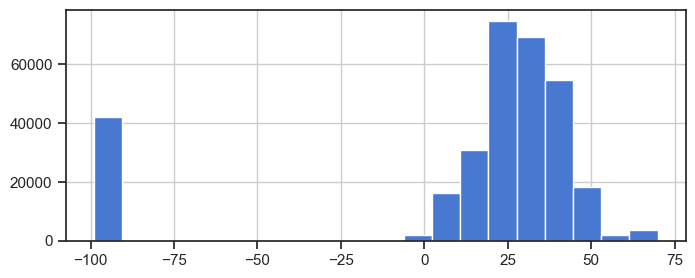

In [28]:
weather_impute['nearest_powiat_dist'].hist(figsize=(8, 3), bins=20);

In [29]:
#Proportion of impute types
weather_impute['impute_type'].value_counts(normalize=True)*100

Nearest 1 Powiat           23.255814
Nearest 2 Powiat           15.697674
Mean Voivodship Weather    13.372093
Nearest 3 Powiat           12.790698
Nearest 4 Powiat           10.465116
Nearest 5 Powiat            6.395349
Nearest 6 Powiat            5.232558
Nearest 7 Powiat            5.232558
Nearest 10 Powiat           2.325581
Nearest 8 Powiat            2.325581
Nearest 9 Powiat            1.744186
Nearest 11 Powiat           0.581395
Nearest 12 Powiat           0.581395
Name: impute_type, dtype: float64

In [30]:
weather_impute['nearest_powiat_dist'].max()

69.875214

In [31]:
weather_impute['nearest_powiat_dist'].min()

-99.0

In [32]:
#Joining datasets using left join (AQ <- weather)

how = 'left'

merged_df = \
df1.merge(weather_impute.drop(['nearest_powiat_dist', 'voivodship', 'impute_type'], axis=1), 
          how=how, 
          on=['powiat_voivod', 'DATE'])


print(f"Total Number of Powiats: {len(merged_df['powiat_voivod'].unique())}")

print()
print(f"Proportion of missing values in % using {how} join")
merged_df.isnull().sum()/len(merged_df)*100

Total Number of Powiats: 198

Proportion of missing values in % using left join


powiat_voivod              0.000000
DATE                       0.000000
LAT                        0.000000
LON                        0.000000
NO2_24H_AVG_POLLUTION     98.484848
O3_24H_AVG_POLLUTION      48.989899
PM10_24H_AVG_POLLUTION     9.090909
PM25_24H_AVG_POLLUTION    65.656566
CC                         0.000000
FG                         0.000000
HU                         0.000000
RR                         0.000000
SD                         0.000000
TG                         0.000000
dtype: float64

In [33]:
#Extracting voivodship
merged_df['voivodship'] = merged_df['powiat_voivod'].str.split(", ").str[1]

In [34]:
np.sort(merged_df['voivodship'].unique())

array(['dolnośląskie', 'kujawsko-pomorskie', 'lubelskie', 'lubuskie',
       'mazowieckie', 'małopolskie', 'opolskie', 'podkarpackie',
       'podlaskie', 'pomorskie', 'warmińsko-mazurskie', 'wielkopolskie',
       'zachodniopomorskie', 'łódzkie', 'śląskie', 'świętokrzyskie'],
      dtype=object)

In [35]:
merged_df.head(2)

,powiat_voivod,DATE,LAT,LON,NO2_24H_AVG_POLLUTION,O3_24H_AVG_POLLUTION,PM10_24H_AVG_POLLUTION,PM25_24H_AVG_POLLUTION,CC,FG,HU,RR,SD,TG,voivodship
0,"powiat aleksandrowski, kujawsko-pomorskie",2017-01-01,52.888422,18.780908,NaN,32.22,24.968064,NaN,4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie
1,"powiat aleksandrowski, kujawsko-pomorskie",2017-01-02,52.888422,18.780908,NaN,34.62,17.943745,NaN,6.167555,36.8,88.4,1.0,0.0,0.5,kujawsko-pomorskie


In [37]:
merged_df.to_csv("AQ_Weather_Merged_Rev1.csv", index=False)